# Generations

### All figures/audio are also saved as pdf/waves in the config folder under plots

In [1]:
import os
import shutil
import librosa
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav
from avgn.signalprocessing.spectrogramming import build_mel_basis
from main_spectrogramming import process_syllable
from avgn.pytorch.spectro_dataset import SpectroDataset

/home/leo/Code/birds_latent_generation/venv/lib/python3.8/site-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Parameters

In [2]:
config_path = "models/VAE_Bird_all_2020-12-19_18-38-25/config.py"
loading_epoch = 40
num_examples_plot = 5

All the reconstructions/interpolations will be done either with
- the test dataset
- data provided y the user in the following dictionnary

## Load model and get dataset

In [3]:
from avgn.pytorch.getters import get_dataloader, get_model_and_dataset
model, dataset_train, dataset_val, optimizer, hparams, config, model_path, config_path = get_model_and_dataset(
        config=config_path, loading_epoch=loading_epoch)

if not os.path.isdir(f'{model.model_dir}/plots'):
    os.mkdir(f'{model.model_dir}/plots')

def plot_wave(x, dB_plot):
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x, sr=sr)
    X = librosa.stft(x)
    X = abs(X)
    X = librosa.amplitude_to_db(X)
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(X, sr=sr, x_axis='time', y_axis='hz')

Using GPUs [0]
##### Dataset
# 60865 syllables
##### Build model
##### Load model


## Prepare data

In [4]:
USE_CUSTOM_SAMPLE = True
# Use own samples for generation
if USE_CUSTOM_SAMPLE:
    data_source = {
        0: {
            'start': {'path': 'data/raw/source_generation/0.wav'},
            'end': {'path': 'data/raw/source_generation/1.wav'},
        },
        1: {
            'start': {'path': 'data/raw/source_generation/0.wav'},
            'end': {'path': 'data/raw/source_generation/2.wav'},
        },
        2: {
            'start': {'path': 'data/raw/source_generation/1.wav'},
            'end': {'path': 'data/raw/source_generation/2.wav'},
        }
    }
    start_data = []
    end_data = []
    for example_ind, examples_dict in data_source.items():
        for name in ['start', 'end']:
            # read file
            syl, _ = prepare_wav(
                wav_loc=examples_dict[name]['path'], hparams=hparams, debug=False)
            mel_basis = build_mel_basis(hparams, hparams.sr, hparams.sr)
            # process syllable
            sn, mSp, _ = process_syllable(
                syl=syl, hparams=hparams, mel_basis=mel_basis, debug=False)
            data_source[example_ind][name]['mSp'] = mSp
            data_source[example_ind][name]['sn'] = sn
            if name == 'start':
                start_data.append(SpectroDataset.process_mSp(mSp))
            elif name == 'end':
                end_data.append(SpectroDataset.process_mSp(mSp))
    all_data = start_data + end_data
    #  Batchify
    start_data = np.stack(start_data)
    end_data = np.stack(end_data)
    all_data = np.stack(all_data)
    custom_data = {
        'start_data': start_data,
        'end_data': end_data,
        'all_data': all_data,
    }
else:
    custom_data = None

test_dataloader = get_dataloader(dataset_type=config['dataset'], dataset=dataset_val,
                                 batch_size=num_examples_plot, shuffle=True)    

## Reconstructions

0


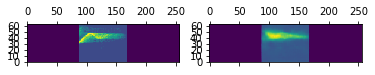

None

1


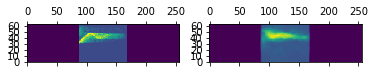

None

2


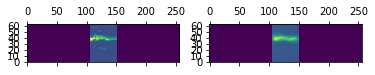

None

3


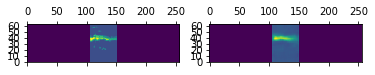

None

4


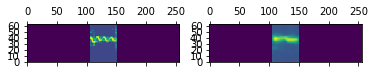

None

5


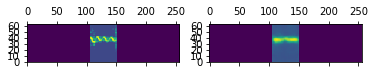

None

In [5]:
from avgn.pytorch.generate.reconstruction import plot_reconstruction

savepath = f'{model.model_dir}/plots/reconstructions'
if os.path.isdir(savepath):
    shutil.rmtree(savepath)
os.mkdir(savepath)
reconstructions = plot_reconstruction(model, hparams, test_dataloader, savepath, custom_data)
o_a = reconstructions['original_audios']
r_a = reconstructions['reconstruction_audios']
o_s = reconstructions['original_spectros']
r_s = reconstructions['reconstruction_spectros']

dims = r_s.shape[2:]

for index in range(len(o_a)):
    print(f'{index}')
    # using tuple unpacking for multiple Axes
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].matshow(o_s[index].reshape(dims), origin="lower")
    axes[1].matshow(r_s[index].reshape(dims), origin="lower")
    ipd.display(
        plt.show(),
        ipd.Audio(o_a[index], rate=hparams.sr),
        ipd.Audio(r_a[index], rate=hparams.sr),
    )

## Generation

0


<Figure size 432x288 with 0 Axes>

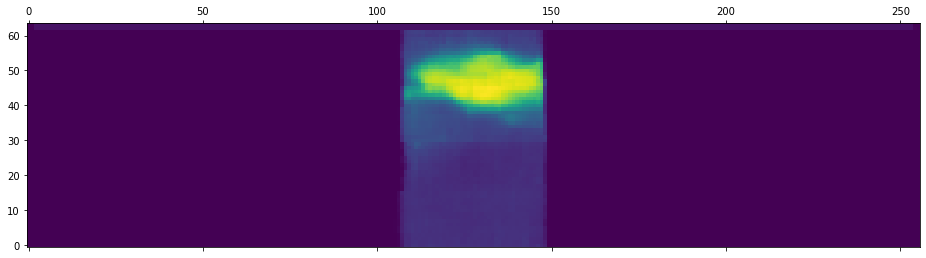

None

1


<Figure size 432x288 with 0 Axes>

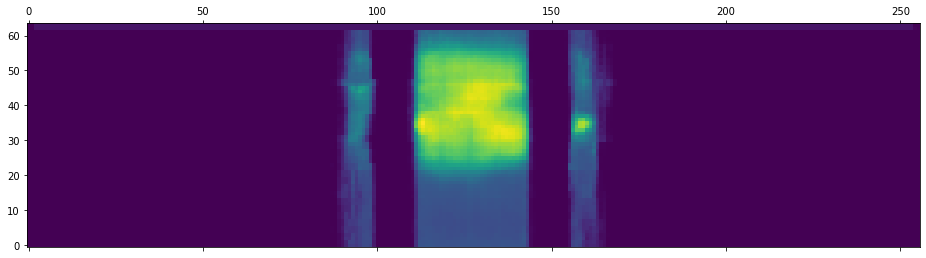

None

2


<Figure size 432x288 with 0 Axes>

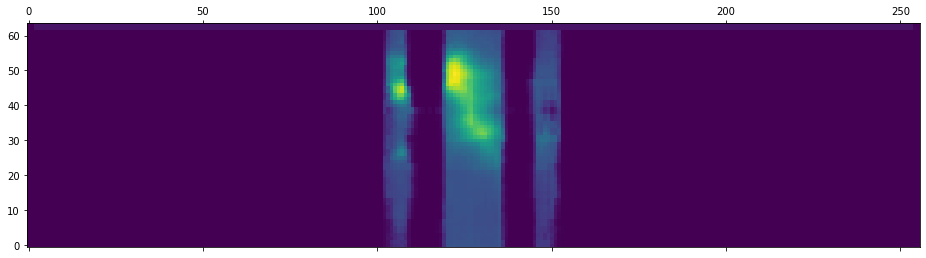

None

3


<Figure size 432x288 with 0 Axes>

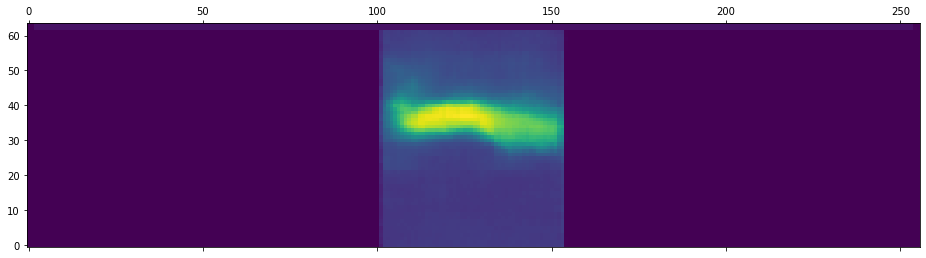

None

4


<Figure size 432x288 with 0 Axes>

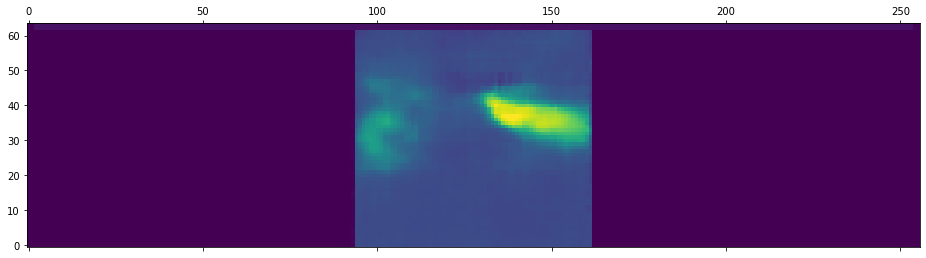

None

In [28]:
from avgn.pytorch.generate.generation import plot_generation


savepath = f'{model.model_dir}/plots/generations'
if os.path.isdir(savepath):
    shutil.rmtree(savepath)
os.mkdir(savepath)
generations = plot_generation(model, hparams, num_examples_plot, savepath)
g_a = generations['audios']
g_s = generations['spectros']
dims = g_s.shape[2:]
for index in range(len(g_a)):
    print(f'{index}')
    # using tuple unpacking for multiple Axes
    plt.figure()
    plt.matshow(g_s[index].reshape(dims), origin="lower")
    ipd.display(
        plt.show(),
        ipd.Audio(g_a[index], rate=hparams.sr),
    )

## Linear interpolations

0


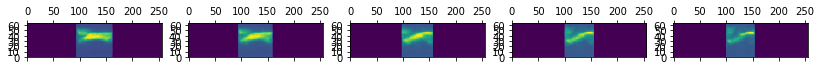

None

1


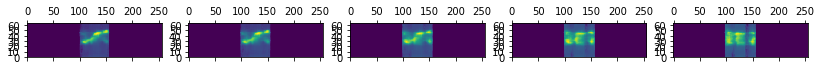

None

2


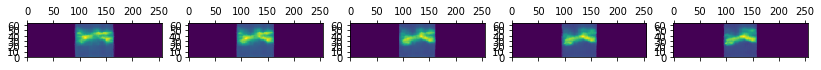

None

In [29]:
from avgn.pytorch.generate.interpolation import plot_interpolations

test_dataloader = get_dataloader(dataset_type=config['dataset'], dataset=dataset_val,
                                 batch_size=num_examples_plot+1, shuffle=True)


num_interpolated_points = 5

savepath = f'{model.model_dir}/plots/linear_interpolations'
if os.path.isdir(savepath):
    shutil.rmtree(savepath)
os.mkdir(savepath)
generations = plot_interpolations(model, hparams, test_dataloader, 
                                  savepath, 
                                  num_interpolated_points=num_interpolated_points, 
                                  method='linear',
                                  custom_data=custom_data)
g_a = generations['audios']
g_s = generations['spectros']
dims = generations['dims']
for index_batch in range(len(g_a)):
    print(f'{index_batch}')
    fig, axes = plt.subplots(nrows=1, ncols=num_interpolated_points, figsize=(14,5))
    for index_interp in range(num_interpolated_points):
        axes[index_interp].matshow(g_s[index_batch, :, :, :, index_interp].reshape(dims), origin="lower")
    ipd.display(
        plt.show(),
        ipd.Audio(g_a[index_batch, index_interp], rate=hparams.sr),
    )

## Constant r interpolation

0


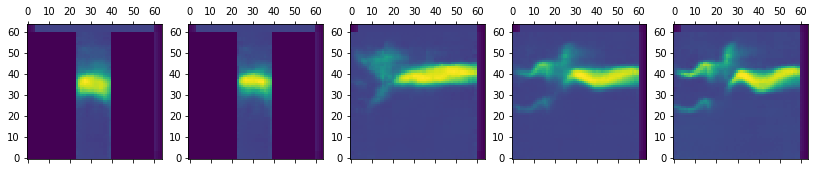

None

1


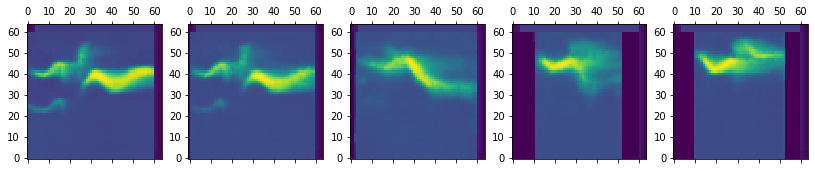

None

2


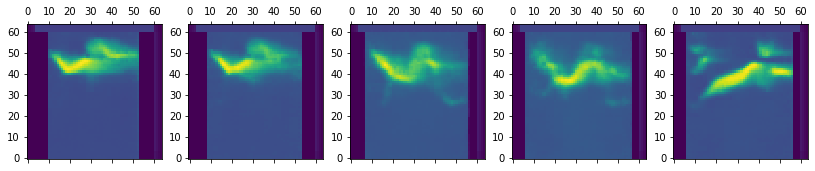

None

3


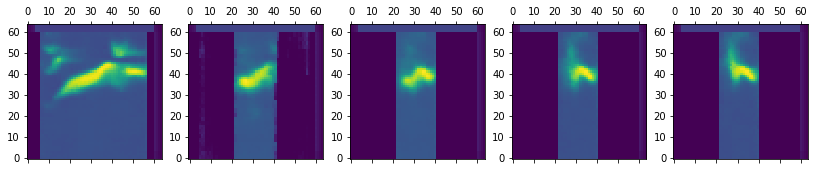

None

4


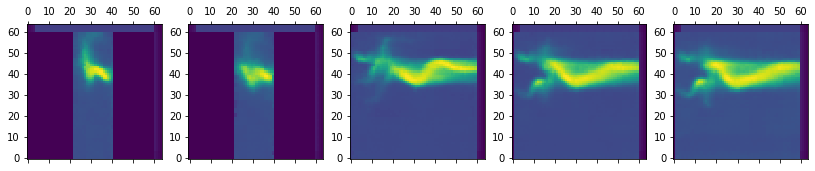

None

In [11]:
from avgn.pytorch.generate.interpolation import plot_interpolations

test_dataloader = get_dataloader(dataset_type=config['dataset'], dataset=dataset_val,
                                 batch_size=num_examples_plot+1, shuffle=True)


num_interpolated_points = 5

savepath = f'{model.model_dir}/plots/constant_r_interpolations'
if os.path.isdir(savepath):
    shutil.rmtree(savepath)
os.mkdir(savepath)
generations = plot_interpolations(model, hparams, test_dataloader, 
                                  savepath, 
                                  num_interpolated_points=num_interpolated_points, 
                                  method='constant_radius',
                                  custom_data=custom_data)
g_a = generations['audios']
g_s = generations['spectros']
dims = generations['dims']
for index_batch in range(len(g_a)):
    print(f'{index_batch}')
    fig, axes = plt.subplots(nrows=1, ncols=num_interpolated_points, figsize=(14,5))
    for index_interp in range(num_interpolated_points):
        axes[index_interp].matshow(g_s[index_batch, :, :, :, index_interp].reshape(dims), origin="lower")
        ipd.display(ipd.Audio(g_a[index_batch, index_interp], rate=hparams.sr))
    ipd.display(plt.show())

## Visualize latent space

<Figure size 432x288 with 0 Axes>

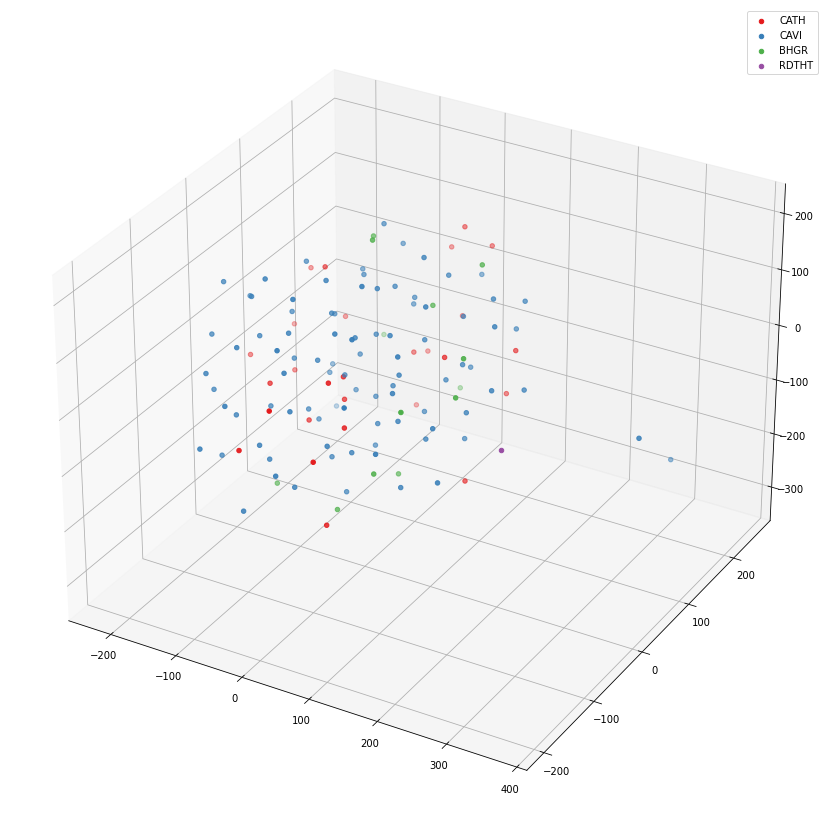

In [4]:
from avgn.pytorch.generate.plot_tsne_latent import plot_tsne_latent

test_dataloader = get_dataloader(dataset_type=config['dataset'], dataset=dataset_val,
                                 batch_size=num_examples_plot+1, shuffle=True)

savepath = f'{model.model_dir}/plots/stats'
if os.path.isdir(savepath):
    shutil.rmtree(savepath)
os.mkdir(savepath)

# plt.show() is inside the function
label_to_points = plot_tsne_latent(model, test_dataloader, savepath)